In [1]:
import csv
import logging
from collections import Counter

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


logging.basicConfig(
    format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s',
    level=logging.INFO
)


def load_embeddings(embedding_path = r"C:\Users\34514\Desktop\NLP\Project\output.npy"):

    embeddings = np.load(embedding_path)
    logging.info(f"加载 embeddings 成功，形状: {embeddings.shape}")
    return embeddings


def load_labels(csv_path = r"C:\Users\34514\Desktop\NLP\Project\诗歌数据.csv"):
    """
    重新读取 CSV，获取 dynasty(era) 和 genre 标签。
    读取逻辑尽量与 MainV1.0.0.py 中的 read_poetry_data 保持一致，
    确保顺序匹配 output.npy。
    """
    contents = []
    dynasties = []
    genres = []

    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            # 先读取几行判断分隔符
            sample_lines = []
            for _ in range(5):
                try:
                    line = next(f)
                    sample_lines.append(line)
                except StopIteration:
                    break
            f.seek(0)

            delimiter = "|" if any("|" in line for line in sample_lines) else ","
            logging.info(f"使用分隔符: {repr(delimiter)}")

            reader = csv.reader(f, delimiter=delimiter)
            header = next(reader, None)  # 跳过表头

            for idx, row in enumerate(reader):
                if len(row) >= 3:
                    try:
                        if len(row) >= 5:
                            title, author, content, dynasty, genre = row[:5]
                        else:
                            title, author, content = row[:3]
                            dynasty, genre = "", ""

                        content = content.strip()
                        if content:  # 只保留非空内容，这样顺序匹配 output.npy
                            contents.append(content)
                            dynasties.append(dynasty.strip())
                            genres.append(genre.strip())
                    except Exception as e:
                        logging.warning(f"处理第{idx+2}行出错: {str(e)}")
                else:
                    logging.warning(f"第{idx+2}行列数不足: {row}")

        logging.info(f"成功读取 {len(contents)} 条有效诗歌记录（含标签）")
        return dynasties, genres

    except FileNotFoundError:
        logging.error(f"未找到文件: {csv_path}")
        raise
    except Exception as e:
        logging.error(f"读取文件出错: {str(e)}")
        raise


def build_era_dataset(embeddings, dynasties):
    """
    根据 dynasty 构建唐/宋二分类数据集
    """
    X = []
    y = []

    for vec, dy in zip(embeddings, dynasties):
        if not dy:
            continue

        # 简单归一化 dynasty 标签，比如 “唐代”“唐朝”“唐” 都归为 “唐”
        if "唐" in dy:
            era = "唐"
        elif "宋" in dy:
            era = "宋"
        else:
            # 其他朝代先丢弃
            continue

        X.append(vec)
        y.append(era)

    X = np.array(X)
    y = np.array(y)
    logging.info(f"年代二分类数据集：X 形状 {X.shape}，样本数={len(y)}，类别分布={Counter(y)}")
    return X, y


def build_genre_dataset(embeddings, genres, min_count=20):
    """
    根据 genre 构建体裁分类数据集
    min_count: 至少出现多少次才保留该体裁，防止类别太多太稀疏
    """
    # 先统计所有体裁的频数
    clean_genres = [g for g in genres if g]
    counter = Counter(clean_genres)
    logging.info(f"所有体裁及频数: {counter}")

    # 只保留出现次数 >= min_count 的体裁
    valid_genres = {g for g, c in counter.items() if c >= min_count}
    logging.info(f"保留的体裁类别(出现 >= {min_count} 次): {valid_genres}")

    X = []
    y = []
    for vec, g in zip(embeddings, genres):
        g = g.strip()
        if g in valid_genres:
            X.append(vec)
            y.append(g)

    X = np.array(X)
    y = np.array(y)
    logging.info(f"体裁分类数据集：X 形状 {X.shape}，样本数={len(y)}，类别分布={Counter(y)}")
    return X, y


def train_and_evaluate_classifier(X, y, task_name="era"):
    """
    使用 LogisticRegression 训练并评估分类器
    """
    if len(X) == 0:
        logging.error(f"{task_name} 数据集为空，无法训练")
        return

    # 划分训练 / 测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y  # 保证各类别比例
    )

    logging.info(f"{task_name} - 训练集大小: {len(y_train)}, 测试集大小: {len(y_test)}")

    # 使用 pipeline: 标准化(不减均值) + 逻辑回归
    # with_mean=False 是因为有时候 embedding 维度较大，不减均值在稀疏/大规模时更稳定
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("logreg", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",  # 类别不平衡时更稳
            n_jobs=-1
        ))
    ])

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    logging.info(f"{task_name} - 测试集准确率: {acc:.4f}")
    print(f"\n=== {task_name} 分类结果 ===")
    print(f"Accuracy: {acc:.4f}\n")
    print("分类报告 (classification report):")
    print(classification_report(y_test, y_pred))
    print("混淆矩阵 (confusion matrix):")
    print(confusion_matrix(y_test, y_pred))

    return clf


def main():
    # 1. 加载 embeddings
    embeddings = load_embeddings("output.npy")

    # 2. 加载标签
    dynasties, genres = load_labels("诗歌数据.csv")

    # 简单检查：数量是否一致
    if embeddings.shape[0] != len(dynasties):
        logging.warning(
            f"警告：embeddings 数量({embeddings.shape[0]}) 与 CSV 记录数({len(dynasties)}) 不一致。"
        )

    # 3. 构建年代二分类数据集并训练
    X_era, y_era = build_era_dataset(embeddings, dynasties)
    era_clf = train_and_evaluate_classifier(X_era, y_era, task_name="era(唐/宋)")

    # 4. 构建体裁分类数据集并训练（可选）
    X_genre, y_genre = build_genre_dataset(embeddings, genres, min_count=20)
    if len(X_genre) > 0:
        genre_clf = train_and_evaluate_classifier(X_genre, y_genre, task_name="genre(体裁)")
    else:
        logging.warning("genre 数据过少或不满足 min_count，跳过体裁分类任务。")


if __name__ == "__main__":
    main()

2025-11-29 22:54:47,694 - 3426323427.py[line:22] - INFO: 加载 embeddings 成功，形状: (6000, 512)
2025-11-29 22:54:47,697 - 3426323427.py[line:49] - INFO: 使用分隔符: ','
2025-11-29 22:54:47,709 - 3426323427.py[line:73] - INFO: 成功读取 6000 条有效诗歌记录（含标签）
2025-11-29 22:54:47,719 - 3426323427.py[line:109] - INFO: 年代二分类数据集：X 形状 (6000, 512)，样本数=6000，类别分布=Counter({'唐': 3000, '宋': 3000})
2025-11-29 22:54:47,727 - 3426323427.py[line:158] - INFO: era(唐/宋) - 训练集大小: 4800, 测试集大小: 1200
2025-11-29 22:54:50,659 - 3426323427.py[line:176] - INFO: era(唐/宋) - 测试集准确率: 0.9875
2025-11-29 22:54:50,668 - 3426323427.py[line:121] - INFO: 所有体裁及频数: Counter({'词': 3232, '律诗': 1244, '绝句': 968, '诗': 479, '其他': 77})
2025-11-29 22:54:50,668 - 3426323427.py[line:125] - INFO: 保留的体裁类别(出现 >= 20 次): {'律诗', '绝句', '诗', '词', '其他'}
2025-11-29 22:54:50,677 - 3426323427.py[line:137] - INFO: 体裁分类数据集：X 形状 (6000, 512)，样本数=6000，类别分布=Counter({'词': 3232, '律诗': 1244, '绝句': 968, '诗': 479, '其他': 77})
2025-11-29 22:54:50,686 - 3426323427.py[line:158] - IN


=== era(唐/宋) 分类结果 ===
Accuracy: 0.9875

分类报告 (classification report):
              precision    recall  f1-score   support

           唐       0.99      0.99      0.99       600
           宋       0.99      0.98      0.99       600

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200

混淆矩阵 (confusion matrix):
[[594   6]
 [  9 591]]


2025-11-29 22:54:53,069 - 3426323427.py[line:176] - INFO: genre(体裁) - 测试集准确率: 0.9133



=== genre(体裁) 分类结果 ===
Accuracy: 0.9133

分类报告 (classification report):
              precision    recall  f1-score   support

          其他       0.40      0.40      0.40        15
          律诗       0.91      0.94      0.92       249
          绝句       0.87      0.93      0.90       194
           词       0.96      0.94      0.95       646
           诗       0.78      0.72      0.75        96

    accuracy                           0.91      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.91      0.91      0.91      1200

混淆矩阵 (confusion matrix):
[[  6   1   4   3   1]
 [  0 233   2   9   5]
 [  2   1 180   8   3]
 [  2  14  11 608  11]
 [  5   8   9   5  69]]


## PCA 可视化

2025-11-29 22:54:55,614 - 3426323427.py[line:49] - INFO: 使用分隔符: ','
2025-11-29 22:54:55,627 - 3426323427.py[line:73] - INFO: 成功读取 6000 条有效诗歌记录（含标签）


embeddings 形状: (6000, 512)
era_labels 长度: 6000
genre_labels 长度: 6000


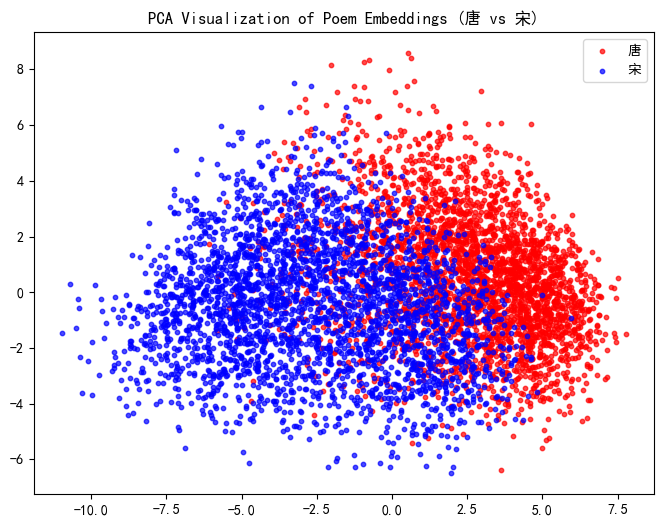

PCA解释的方差比例: [0.13961681 0.0517208 ]
累计解释方差: 0.1913


In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 1. 重新加载 embeddings 和标签
embeddings = np.load("output.npy")
dynasties, genres = load_labels("诗歌数据.csv")

# 2. 构建 era_labels
era_labels = []
for dy in dynasties:
    if not dy:
        era_labels.append("")
    elif "唐" in dy:
        era_labels.append("唐")
    elif "宋" in dy:
        era_labels.append("宋")
    else:
        era_labels.append("")

# 3. 构建 genre_labels（直接使用 genres）
genre_labels = genres

# 4. 确保 embeddings 和标签长度一致
print(f"embeddings 形状: {embeddings.shape}")
print(f"era_labels 长度: {len(era_labels)}")
print(f"genre_labels 长度: {len(genre_labels)}")

# ===== PCA =====
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

# ===== 可视化（按 era 着色） =====
plt.figure(figsize=(8,6))
colors = {"唐": "red", "宋": "blue"}

for era in colors:
    idx = [i for i, e in enumerate(era_labels) if e == era]
    if idx:  # 确保有数据点
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                    c=colors[era], label=era, s=10, alpha=0.7)

plt.title("PCA Visualization of Poem Embeddings (唐 vs 宋)")
plt.legend()
plt.show()

# 可选：查看PCA解释的方差比例
print(f"PCA解释的方差比例: {pca.explained_variance_ratio_}")
print(f"累计解释方差: {sum(pca.explained_variance_ratio_):.4f}")

## t-SNE 可视化

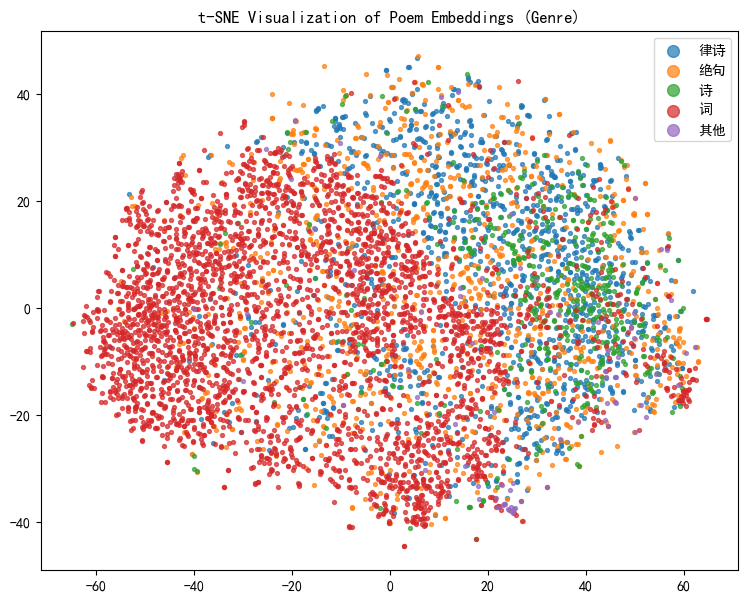

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# ===== t-SNE =====
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=30)
X_tsne = tsne.fit_transform(embeddings)

# ===== 可视化（按 genre 着色） =====
plt.figure(figsize=(9,7))

genre_list = list(set(genre_labels))
colors = plt.cm.tab10(range(len(genre_list)))

for g, c in zip(genre_list, colors):
    idx = [i for i, x in enumerate(genre_labels) if x == g]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                s=8, c=[c], label=g, alpha=0.7)

plt.title("t-SNE Visualization of Poem Embeddings (Genre)")
plt.legend(markerscale=3)
plt.show()

## UMAP可视化

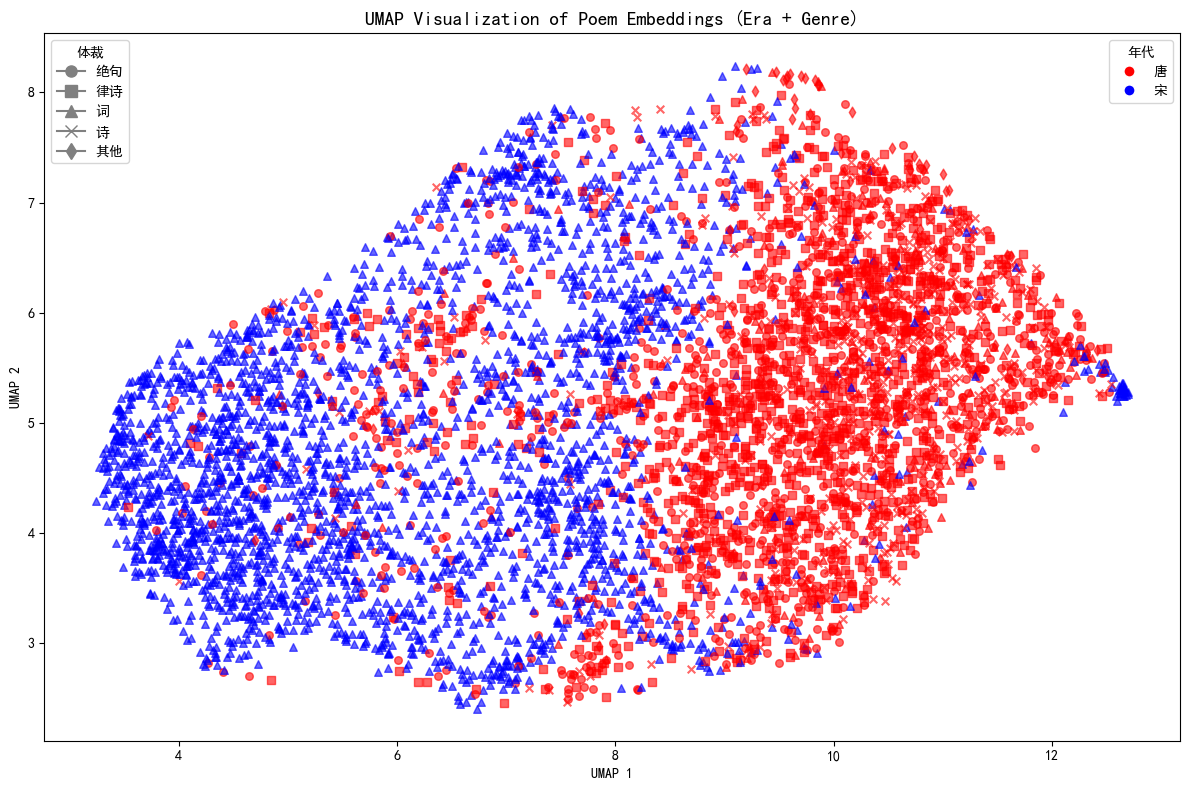

In [4]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ===== UMAP =====
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric='cosine')
X_umap = reducer.fit_transform(embeddings)

# ===== 可视化 =====
plt.figure(figsize=(12, 8))

colors = {"唐": "red", "宋": "blue"}
markers = {
    "绝句": "o",
    "律诗": "s", 
    "词": "^",
    "诗": "x",
    "其他": "d"
}

# 绘制散点
for i in range(len(embeddings)):
    plt.scatter(X_umap[i, 0], X_umap[i, 1],
                c=colors[era_labels[i]],
                marker=markers[genre_labels[i]],
                s=30, alpha=0.6)

# 创建图例元素
# 颜色图例（年代）
color_legend_elements = [Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor=color, markersize=8, label=era)
                        for era, color in colors.items()]

# 标记图例（体裁）
marker_legend_elements = [Line2D([0], [0], marker=marker, color='gray', 
                                markerfacecolor='gray', markersize=8, label=genre)
                         for genre, marker in markers.items()]

# 添加图例
legend1 = plt.legend(handles=color_legend_elements, loc='upper right', 
                     title="年代", title_fontsize=10)
legend2 = plt.legend(handles=marker_legend_elements, loc='upper left', 
                     title="体裁", title_fontsize=10)

# 添加第二个图例后需要重新添加第一个图例
plt.gca().add_artist(legend1)

plt.title("UMAP Visualization of Poem Embeddings (Era + Genre)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()